### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 6
### Due: Saturday, Mar 14th at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [11]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

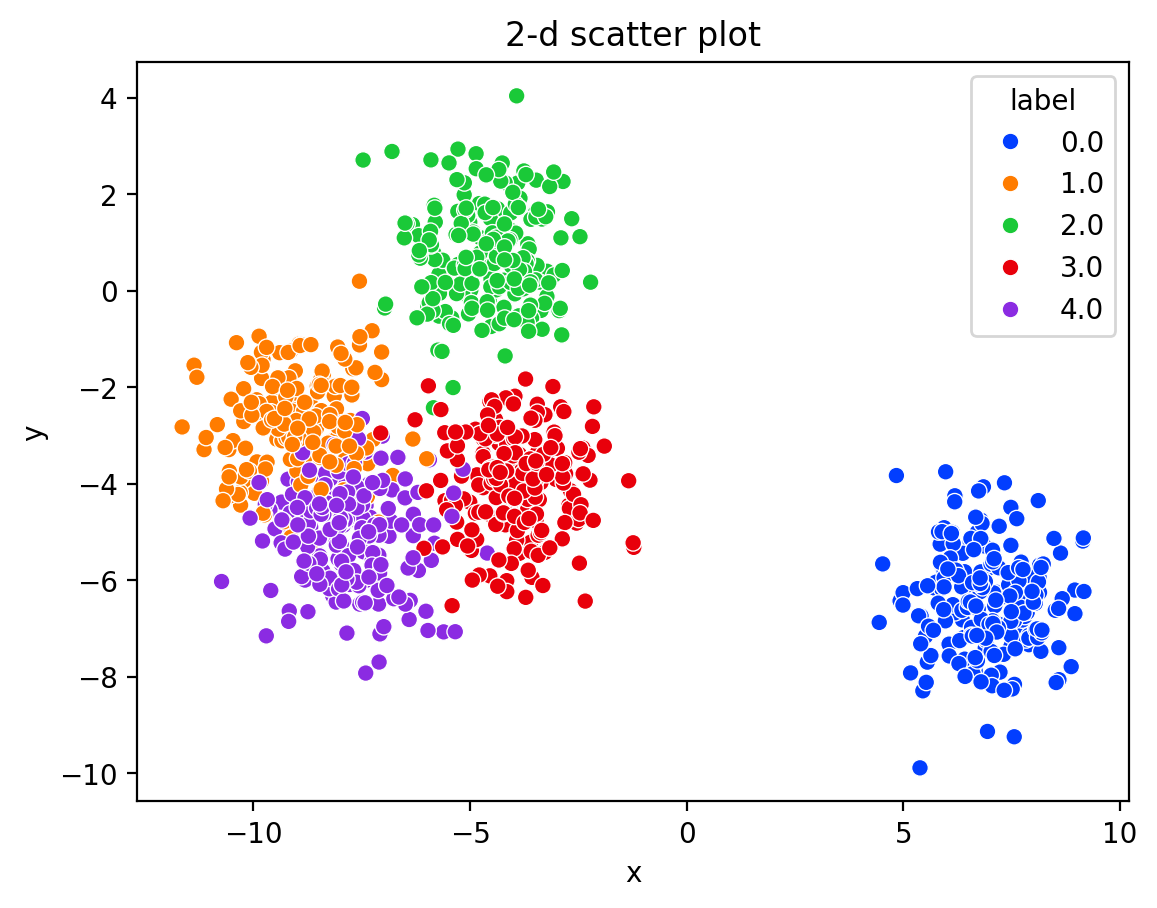

In [17]:
#SOLUTION 1
data = np.load('/home/shwetha/repos/ASTR_3300_S2025/coursework/homeworks/hw_data/hw6_data_1.npy')

x= data[:,0]
y=data[:,1]

df = pd.DataFrame(data,columns=['x','y','label'])
sns.scatterplot(data=df, x='x', y='y', hue='label',palette='bright')
plt.title("2-d scatter plot")
plt.show()

0.28620689655172415


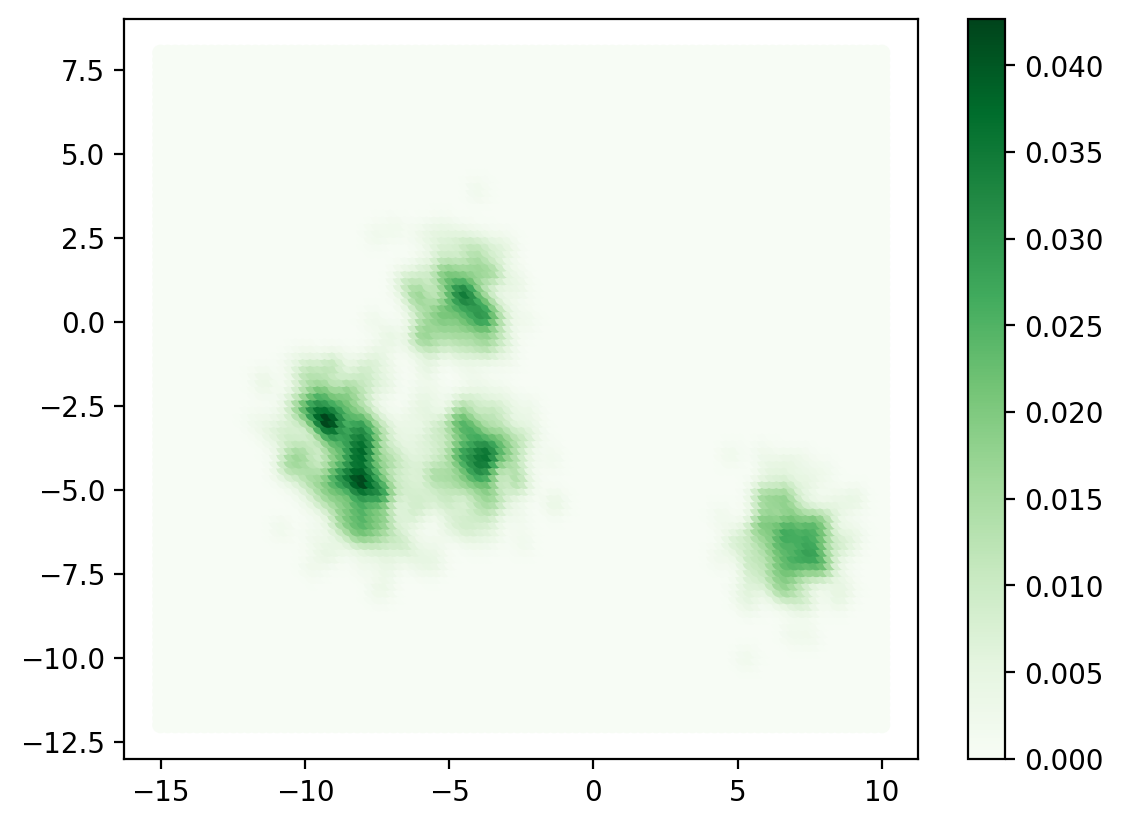

In [28]:
#SOLUTION 2

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV


X = data[:,0:2]
bwrange = np.linspace(0.1, 1.0, 30)
K = 5
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K)
grid.fit(x[:, None])
h_opt = grid.best_params_['bandwidth']
print(h_opt)


kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(X)

u = np.linspace(-15,10,100)
v = np.linspace(-12,8,100)

Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid))

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, cmap="Greens", edgecolor="None")
plt.colorbar()
plt.show()

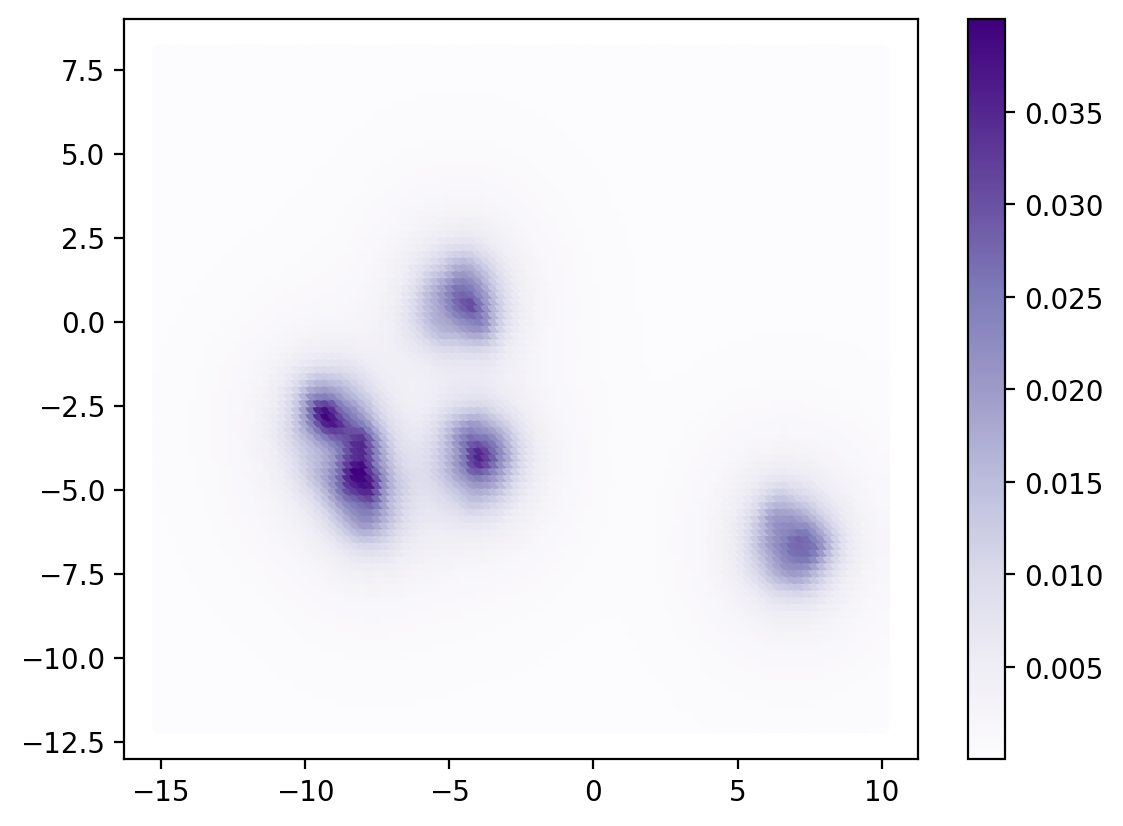

In [36]:
#SOLUTION 3

from astroML.density_estimation import KNeighborsDensity
from sklearn.neighbors import KernelDensity

k  = 60
N = len(data)
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(X)
dens_nbrs = nbrs.eval(Xgrid) / N

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbrs, cmap="Purples", edgecolor="None")
plt.colorbar()
plt.show()

Optimal number according to BIC is 4


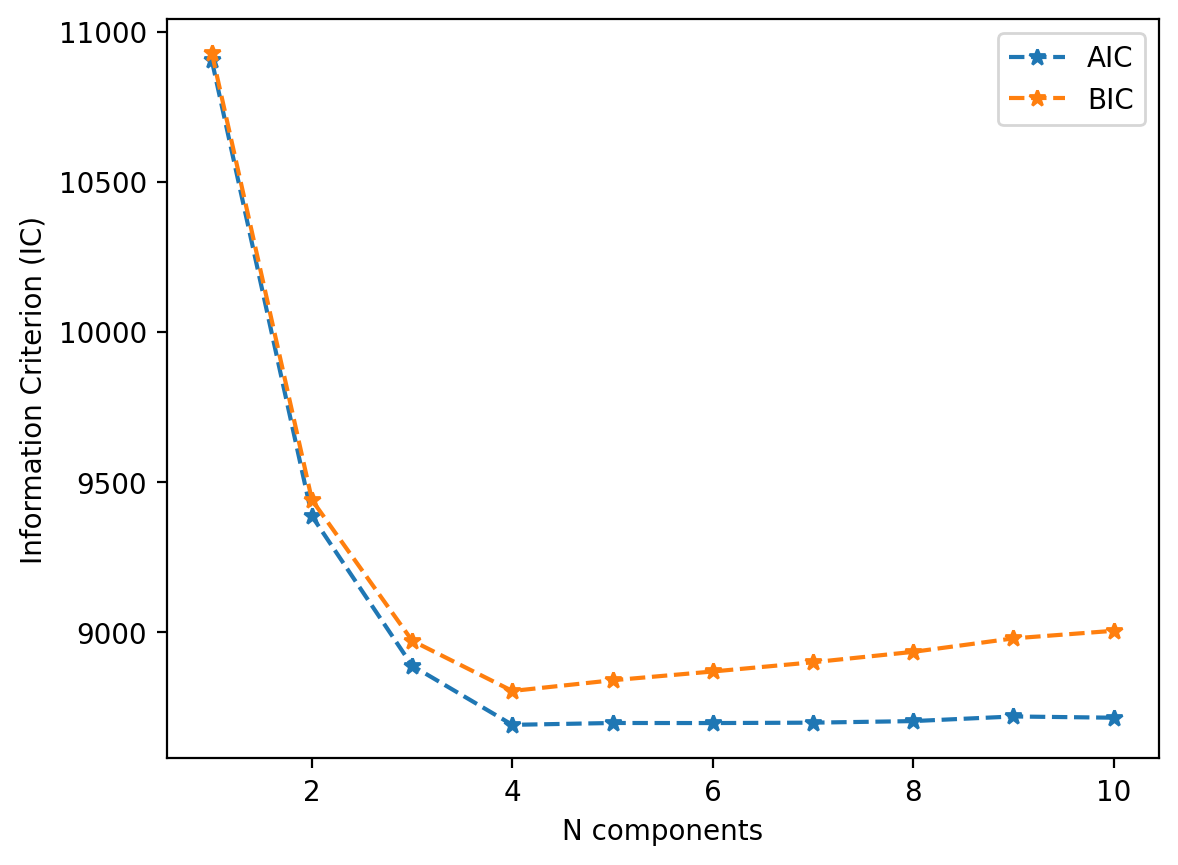

In [48]:
#SOLUTION 4

from sklearn.mixture import GaussianMixture

N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]



plt.plot(N,AIC,marker='*',ls='--',label="AIC")
plt.plot(N,BIC,marker='*',ls='--',label="BIC")
plt.legend()
plt.xlabel("N components")
plt.ylabel("Information Criterion (IC)")
print("Optimal number according to BIC is 4")
plt.show()

In [49]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

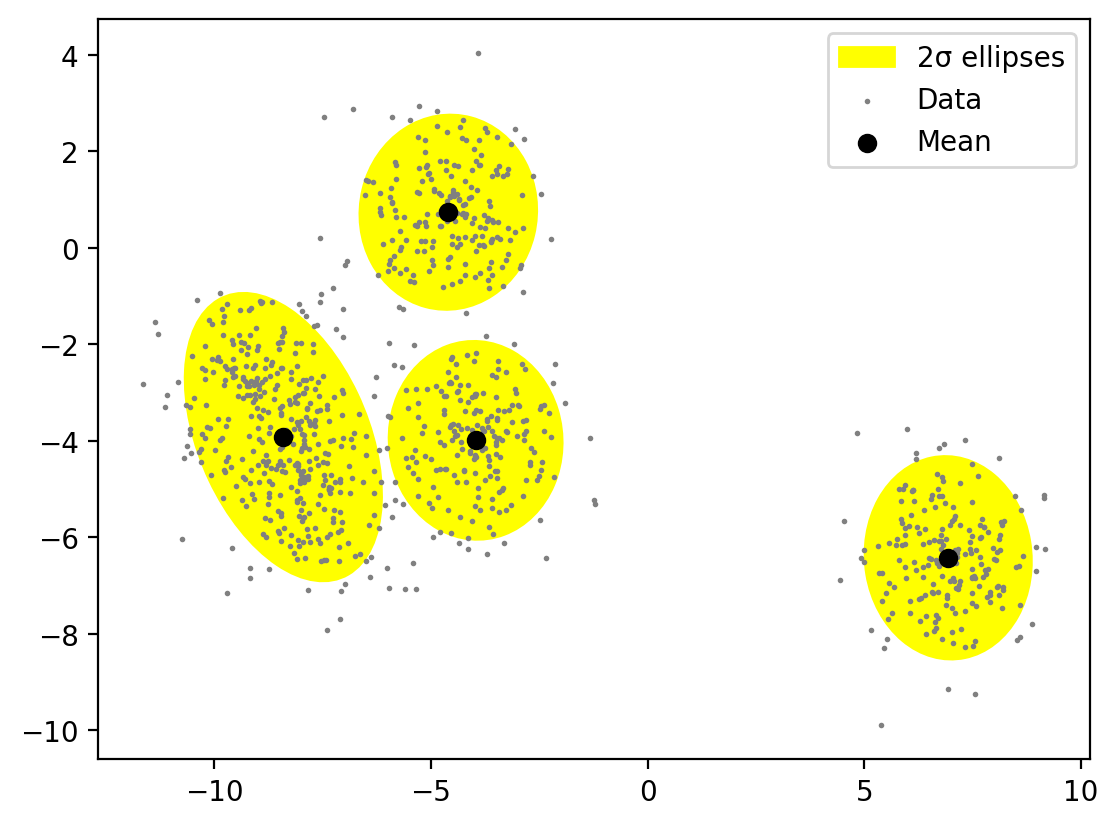

In [75]:
#SOLUTION 5

n = 4
model = GaussianMixture(n).fit(X)
mu_vals = model.means_
C_vals  = model.covariances_


for i in range(len(mu_vals)):
    mu = mu_vals[i]
    C  = C_vals[i]
    if i == 0:
        draw_ellipse(mu, C, scales=[2], color='yellow',label="2σ ellipses")
    else:
        draw_ellipse(mu, C, scales=[2], color='yellow')

plt.scatter(x,y,s=1,c='grey',label='Data') 
plt.scatter(mu_vals[:,0],mu_vals[:,1],c='black',label='Mean')
plt.legend()
plt.show()


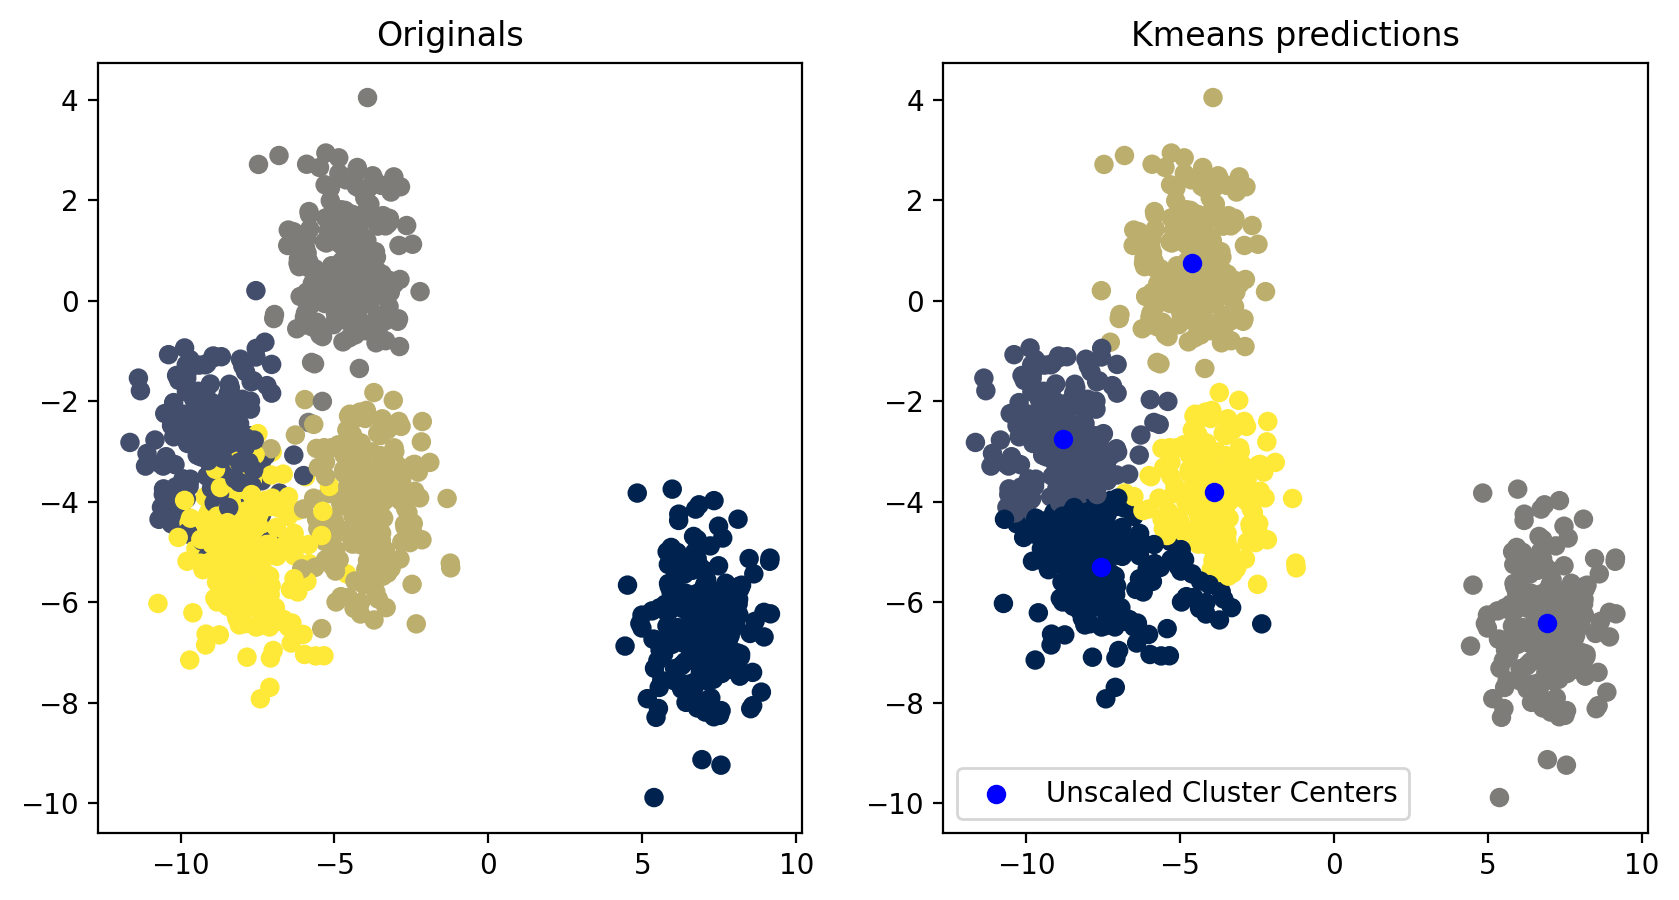

In [85]:
# KMEANS CLUSTERING

from sklearn.cluster import KMeans
from sklearn import preprocessing

n_clusters = 5
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X))

scaled_centers = clf.cluster_centers_
unscaled_centers = scaler.inverse_transform(scaled_centers)
labels = clf.predict(scaler.transform(X))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(x,y,c=data[:,2],cmap='cividis')
ax1.set_title("Originals")


ax2.scatter(x,y,c=labels,cmap='cividis') # Predicted Labels
ax2.scatter(unscaled_centers[:,0],unscaled_centers[:,1],c='blue',label="Unscaled Cluster Centers")
ax2.set_title("Kmeans predictions") 
plt.legend()
plt.show()

<span style="color:green">NP: correct! good job!</span>